In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import os, sys
import numpy as np

from numpy.random import choice
import pandas as pd
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('white')
np.random.seed(seed=42)

In [5]:
results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
with pd.HDFStore('data.h5') as store:
    data =store['us/equities/monthly']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77788 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77788 non-null  float64
 1   bb_down        77788 non-null  float64
 2   bb_high        77788 non-null  float64
 3   bb_low         77788 non-null  float64
 4   bb_mid         77788 non-null  float64
 5   bb_up          77788 non-null  float64
 6   macd           77788 non-null  float64
 7   natr           77788 non-null  float64
 8   rsi            77788 non-null  float64
 9   sector         77788 non-null  object 
 10  return_1m      77788 non-null  float64
 11  return_3m      77788 non-null  float64
 12  return_6m      77788 non-null  float64
 13  return_12m     77788 non-null  float64
 14  beta           77788 non-null  float64
 15  SMB            77788 non-null  float64
 16  HML            7778

In [7]:
y = data.target
y_binary = (y>0).astype(int)
X = pd.get_dummies(data.drop('target', axis=1))

In [8]:
X

atr   bb_down   bb_high    bb_low    bb_mid     bb_up  \
ticker date                                                                     
A      2006-12-31 -0.442397  0.072112  3.223450  3.137767  3.180609  0.013571   
       2007-01-31 -0.520562  0.016425  3.207382  3.111725  3.159553  0.079232   
       2007-02-28 -0.464587  0.008895  3.177726  3.111756  3.144741  0.057075   
       2007-03-31 -0.497099  0.099084  3.191225  3.078332  3.134779  0.013810   
       2007-04-30 -0.552364  0.007060  3.234956  3.189514  3.212235  0.038382   
...                     ...       ...       ...       ...       ...       ...   
ZION   2017-07-31 -0.181012  0.038654  3.841345  3.794321  3.817833  0.008370   
       2017-08-31 -0.274439  0.013926  3.849378  3.785152  3.817265  0.050299   
       2017-09-30 -0.155049  0.139050  3.884183  3.735894  3.810038  0.009239   
       2017-10-31 -0.134904  0.016495  3.889834  3.843392  3.866613  0.029946   
       2017-11-30  0.125608  0.120711  3.918737  3.802252  3.860494 -0.004226   

                       macd      natr        rsi  return_1m  ...  \
ticker date                                                  ...   
A      2006-12-31  0.188915  2.037431  60.772801   0.094535  ...   
       2007-01-31 -0.366521  1.886539  35.388712  -0.081779  ...   
       2007-02-28 -0.116034  2.141267  39.517738  -0.007812  ...   
       2007-03-31  0.196264  1.886661  65.552439   0.061102  ...   
       2007-04-30  0.234341  1.630554  48.928443   0.020184  ...   
...                     ...       ...        ...        ...  ...   
ZION   2017-07-31  0.657033  1.885520  62.089693   0.032111  ...   
       2017-08-31 -0.259812  1.804202  43.528169  -0.034067  ...   
       2017-09-30  0.876060  1.844395  70.270187   0.080623  ...   
       2017-10-31  0.270798  1.902929  51.467907  -0.015261  ...   
       2017-11-30  0.698692  2.147435  69.398587   0.066509  ...   

                   sector_Consumer Durables  sector_Consumer Non-Durables  \
ticker date                                                                 
A      2006-12-31                         0                             0   
       2007-01-31                         0                             0   
       2007-02-28                         0                             0   
       2007-03-31                         0                             0   
       2007-04-30                         0                             0   
...                                     ...                           ...   
ZION   2017-07-31                         0                             0   
       2017-08-31                         0                             0   
       2017-09-30                         0                             0   
       2017-10-31                         0                             0   
       2017-11-30                         0                             0   

                   sector_Consumer Services  sector_Energy  sector_Finance  \
ticker date                                                                  
A      2006-12-31                         0              0               0   
       2007-01-31                         0              0               0   
       2007-02-28                         0              0               0   
       2007-03-31                         0              0               0   
       2007-04-30                         0              0               0   
...                                     ...            ...             ...   
ZION   2017-07-31                         0              0               1   
       2017-08-31                         0              0               1   
       2017-09-30                         0              0               1   
       2017-10-31                         0              0               1   
       2017-11-30                         0              0               1   

                   sector_Health Care  sector_Miscellaneous  \
ticke

In [9]:
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [10]:
rf_clf = RandomForestClassifier(n_estimators=100,             # default changed from 10 to 100 in version 0.22
                                criterion='gini',
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=42,
                                verbose=1)

In [11]:
cv_score = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y_binary,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=1,
                           verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent w

In [12]:
cv_score

array([0.50585133, 0.48662103, 0.4606575 , 0.53165669, 0.54884831,
       0.57231391, 0.45150679, 0.47150378, 0.59258883, 0.55051659])

In [13]:
np.mean(cv_score)

0.5172064766655866

In [14]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)

In [15]:
rf_reg = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=None,
                                verbose=0,
                                warm_start=False)

In [16]:
cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


In [17]:

np.mean(cv_score)

0.006779682340253253

In [18]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}

In [19]:
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [20]:
gridsearch_clf.fit(X=X, y=y_binary)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x0000023DB8D0C2B0>,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [21]:
joblib.dump(gridsearch_clf, results_path / 'gridsearch_clf.joblib')

['results\\random_forest\\gridsearch_clf.joblib']

In [22]:
gridsearch_clf = joblib.load(results_path / 'gridsearch_clf.joblib')

In [23]:
gridsearch_clf.best_params_

{'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 50}

In [24]:
gridsearch_clf.best_score_

0.5209922438141643

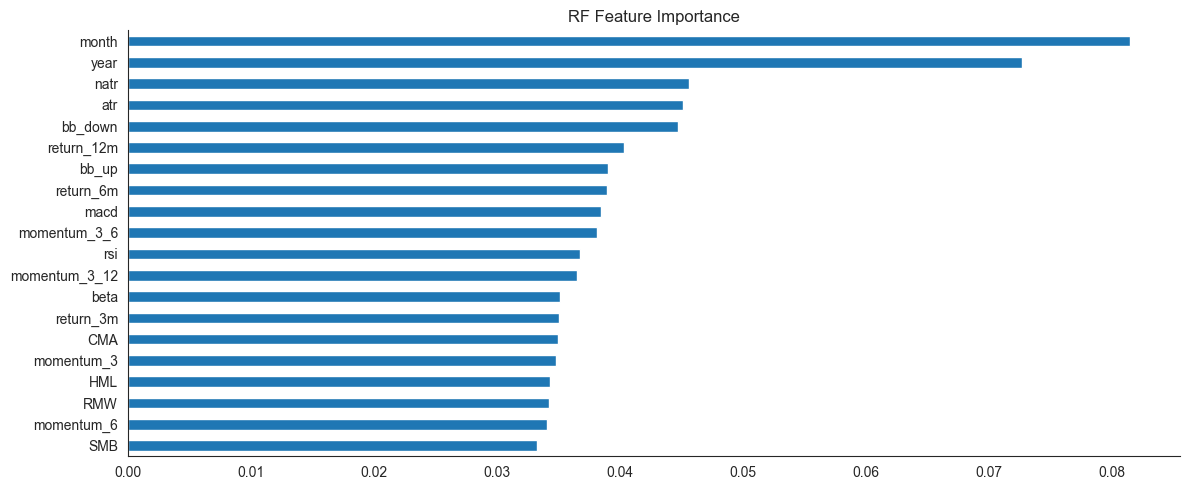

In [25]:
fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_,
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()
fig.tight_layout();

In [26]:
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                      cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)

In [27]:
gs_reg = gridsearch_reg

In [28]:
gridsearch_reg.fit(X=X, y=y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x0000023DB8D0C2B0>,
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring=make_scorer(rank_correl),
             verbose=1)

In [29]:
joblib.dump(gridsearch_reg, results_path / 'rf_reg_gridsearch.joblib')

['results\\random_forest\\rf_reg_gridsearch.joblib']

In [30]:
gridsearch_reg = joblib.load(results_path / 'rf_reg_gridsearch.joblib')

In [31]:
gridsearch_reg.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}

In [32]:
f'{gridsearch_reg.best_score_*100:.2f}'

'4.67'

In [33]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,5,15
min_samples_leaf,5,5
n_estimators,100,50


In [34]:
fig_clf = gridsearch_clf.best_estimator_.feature_importances_
fig_reg = gridsearch_reg.best_estimator_.feature_importances_

In [35]:
idx = [c.replace('_', ' ').upper() for c in X.columns]

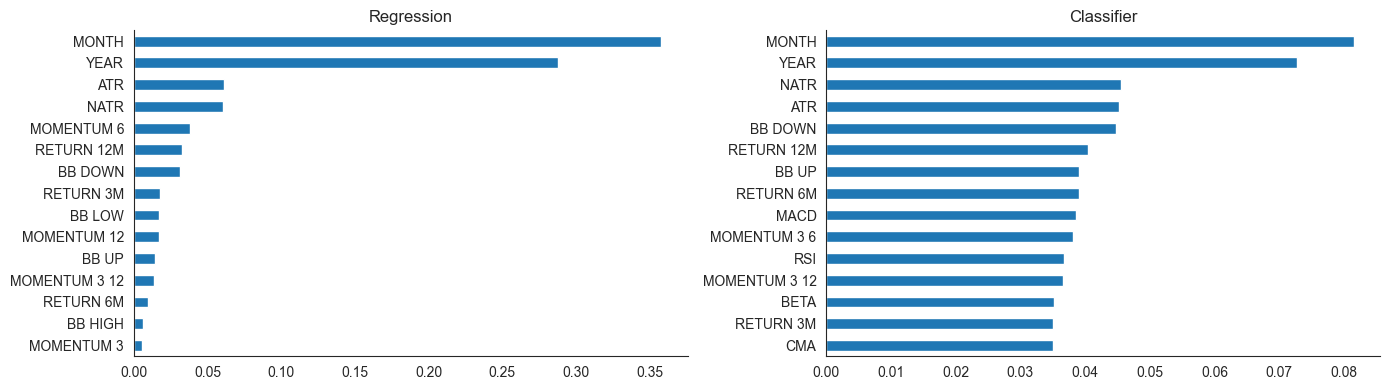

In [38]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
(pd.Series(fig_clf, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[1], title='Classifier'))
(pd.Series(fig_reg, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[0], title='Regression'))
sns.despine()
fig.tight_layout()